# Topics – Easy Topic Modeling in Python

The text mining technique **Topic Modeling** has become a popular statistical method for clustering documents. This [Jupyter notebook](http://jupyter.org/) introduces a step-by-step workflow, basically containing data preprocessing, the actual topic modeling using **latent Dirichlet allocation** (LDA), which learns the relationships between words, topics, and documents, as well as some interactive visualizations to explore the model.

LDA, introduced in the context of text analysis in [2003](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), is an instance of a more general class of models called **mixed-membership models**. Involving a number of distributions and parameters, the topic model is typically performed using [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) with conjugate priors and is purely based on word frequencies.

There have been written numerous introductions to topic modeling for humanists (e.g. [this one](http://scottbot.net/topic-modeling-for-humanists-a-guided-tour/)), which provide another level of detail regarding its technical and epistemic properties.

For this workflow, you will need a corpus (a set of texts) as plain text (`.txt`) or [TEI XML](http://www.tei-c.org/index.xml) (`.xml`). Using the `dariah_topics` package, you also have the ability to process the output of [DARIAH-DKPro-Wrapper](https://github.com/DARIAH-DE/DARIAH-DKPro-Wrapper), a command-line tool for *natural language processing*.

Topic modeling works best with very large corpora. The [TextGrid Repository](https://textgridrep.org/) is a great place to start searching for text data. Anyway, to demonstrate the technique, we provide one small text collection in the folder `grenzboten_sample` containing 15 diary excerpts, as well as 15 war diary excerpts, which appeared in *Die Grenzboten*, a German newspaper of the late 19th and early 20th century.

**Of course, you can work with your own corpus in this notebook.**

We're relying on the LDA implementation by [Allen B. Riddell](https://www.ariddell.org/), called [lda](http://pythonhosted.org/lda/index.html), which is very lightweight. Aside from that, we provide two more Jupyter notebooks:

* [IntroducingMallet](IntroducingMallet.ipynb), using LDA by [MALLET](http://mallet.cs.umass.edu/topics.php), which is known to be very robust. 
* [IntroducingGensim](IntroducingGensim.ipynb), using LDA by called [Gensim](https://radimrehurek.com/project/gensim/), which is attractive because of its multi-core support.

For more information in general, have a look at the [documentation](http://dev.digital-humanities.de/ci/job/DARIAH-Topics/doclinks/1/).

## First step: Installing dependencies

To work within this Jupyter notebook, you will have to import the `dariah_topics` library. As you do, `dariah_topics` also imports a couple of external libraries, which have to be installed first. `pip` is the preferred installer program in Python. Starting with Python 3.4, it is included by default with the Python binary installers. If you are interested in `pip`, have a look at [this website](https://docs.python.org/3/installing/index.html).

To install the `dariah_topics` library with all dependencies, open your commandline, go with `cd` to the folder `Topics` and run:

```
pip install -r requirements.txt
```

Alternatively, you can do:

```
python setup.py install
```

If you get any errors or are not able to install *all* dependencies properly, try [Stack Overflow](https://stackoverflow.com/questions/tagged/pip) for troubleshooting or create a new issue on our [GitHub page](https://github.com/DARIAH-DE/Topics).

**Important**: If you are on macOS or Linux, you will have to use `pip3` and `python3`.

### Some final words
As you already know, code has to be written in the grey cells. You execute a cell by clicking the **Run**-button. If you want to run all cells of the notebook at once, click **Cell > Run All** or **Kernel > Restart & Run All** respectively, if you want to restart the Python kernel first. On the left side of an (unexecuted) cell stands `In [ ]:`. The empty bracket means, that the cell hasn't been executed yet. By clicking **Run**, a star appears in the brackets (`In [*]:`), which means the process is running. In most cases, you won't see that star, because your computer is faster than your eyes. You can execute only one cell at once, all following executions will be in the waiting line. If the process of a cell is done, a number appears in the brackets (`In [1]:`).

## Starting with topic modeling!

Execute the following cell to import modules from the `dariah_topics` library.

In [1]:
from dariah_topics import preprocessing
from dariah_topics import meta
from dariah_topics import postprocessing
from dariah_topics import visualization

Furthermore, we will need some additional functions from external libraries.

In [2]:
from bokeh.io import show
import lda

Let's not pay heed to any warnings right now and execute the following cell.

In [3]:
import warnings
warnings.filterwarnings('ignore')

The following line will just tell the notebook to show graphics in the output frames.

In [4]:
%matplotlib inline

## 1. Preprocessing

### 1.2. Reading a corpus of documents

#### Defining the path to the corpus folder

In the present example code, we are using the 30 diary excerpts from the folder `grenzboten`. To use your own corpus, change the path accordingly.

In [5]:
path_to_corpus = 'grenzboten_sample/*.txt'

By adding `/*.txt` to the actual path, we make sure to select only files with the suffix `.txt`.

#### Accessing file paths and metadata
We begin by creating a list of all the documents in the folder specified above. That list will tell the function `preprocessing.read_from_pathlist` (see below) which text documents to read. Furthermore, based on filenames we can create some metadata, e.g. author and title.

In [6]:
metadata = meta.fn2metadata(path_to_corpus)
metadata[:5] # by adding '[:5]' to the variable, only the first 5 elements will be printed

,author,basename,filename,title
0,Beck,Beck_1844_Tagebuch_56,grenzboten_sample/Beck_1844_Tagebuch_56.txt,1844_Tagebuch_56
1,Unbekannt,Unbekannt_1844_Tagebuch_70,grenzboten_sample/Unbekannt_1844_Tagebuch_70.txt,1844_Tagebuch_70
2,Nimmer,Nimmer_1844_Tagebuch_77,grenzboten_sample/Nimmer_1844_Tagebuch_77.txt,1844_Tagebuch_77
3,Unbekannt,Unbekannt_1844_Tagebuch_82,grenzboten_sample/Unbekannt_1844_Tagebuch_82.txt,1844_Tagebuch_82
4,Jörgel,Jörgel_1844_Tagebuch_88,grenzboten_sample/Jörgel_1844_Tagebuch_88.txt,1844_Tagebuch_88


#### Read listed documents from folder

In [7]:
corpus = list(preprocessing.read_from_pathlist(metadata['filename']))
corpus[0][:255] # printing the first 255 characters of the first document

'Tagebuch von Karl Beck. Man spricht seit vierzehn Tagen von einem vollständigen Ministerwechsel und es circuliren im Publicum die verschiedensten Combinationen, wobei heute ganz andere Namen genannt werden, als gestern und morgen wieder andere, als heute.'

Your `corpus` contains as much elements (`documents`) as texts in your corpus are. Each element of `corpus` is a list containing exactly one element, the text itself as one single string including all whitespaces and punctuations:

```
[['This is the content of your first document.'],
 ['This is the content of your second document.'],
 ...
 ['This is the content of your last document.']]
```

### 1.3. Tokenize corpus
Now, your `documents` in `corpus` will be tokenized. Tokenization is the task of cutting a stream of characters into linguistic units, simply words or, more precisely, tokens. The tokenize function `dariah_topics` provides is a simple Unicode tokenizer. Depending on the corpus, it might be useful to use an external tokenizer function, or even develop your own, since its efficiency varies with language, epoch and text type.

In [8]:
tokenized_corpus = [list(preprocessing.tokenize(document)) for document in corpus]

At this point, each `document` is represented by a list of separate token strings. As above, have a look at the first document (which has the index `0` as Python starts counting at 0) and show its first 14 words/tokens (that have the indices `0:13` accordingly).

In [9]:
tokenized_corpus[0][0:13]

['tagebuch',
 'von',
 'karl',
 'beck',
 'man',
 'spricht',
 'seit',
 'vierzehn',
 'tagen',
 'von',
 'einem',
 'vollständigen',
 'ministerwechsel']

### 1.4. Create a document-term matrix

The LDA topic model is based on a [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix) of the corpus. In a document-term matrix, rows correspond to documents and columns correspond to terms or tokens respectively. The values are token frequencies for each document.

In [10]:
document_term_matrix = preprocessing.create_document_term_matrix(tokenized_corpus, metadata['title'])
document_term_matrix[:5]

,die,der,und,in,den,von,zu,das,des,nicht,...,staatsmonopol,steigernde,staatspapieren,staatsrücksichten,staatszeitung,stallknecht,stammen,starkem,statu,subscriben
1844_Tagebuch_56,90.0,92.0,84.0,70.0,30.0,26.0,25.0,16.0,25.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_70,205.0,224.0,193.0,133.0,78.0,64.0,112.0,86.0,45.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_77,181.0,153.0,141.0,98.0,55.0,59.0,72.0,59.0,44.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_82,213.0,207.0,169.0,128.0,85.0,86.0,79.0,80.0,66.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_88,68.0,59.0,70.0,54.0,22.0,27.0,28.0,19.0,13.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.5. Feature removal

*Stopwords* (also known as *most frequent tokens*) and *hapax legomena* are harmful for LDA and have to be removed from the corpus or the document-term matrix respectively. In this example, the 50 most frequent tokens will be categorized as stopwords.

**Hint**: Be careful with removing most frequent tokens, you might remove tokens quite important for LDA. Anyway, to gain better results, it is highly recommended to use an external stopwords list.

In this notebook, we combine the 50 most frequent tokens, hapax legomena and an external stopwordslist.

#### List the 100 most frequent tokens

In [11]:
stopwords = preprocessing.find_stopwords(document_term_matrix, most_frequent_tokens=100)

These are the five most frequent words:

In [12]:
stopwords[:5]

['die', 'der', 'und', 'in', 'den']

#### List hapax legomena

In [13]:
hapax_legomena = preprocessing.find_hapax_legomena(document_term_matrix)
print("Total number of types in corpus:", document_term_matrix.shape[1])
print("Total number of hapax legomena:", len(hapax_legomena))

Total number of types in corpus: 24451
Total number of hapax legomena: 19757


#### Optional: Use external stopwordlist

In [14]:
path_to_stopwordlist = "tutorial_supplementals/stopwords/de.txt"
external_stopwords = [line.strip() for line in open(path_to_stopwordlist, 'r', encoding='utf-8')]

#### Combine lists and remove content from `document_term_matrix`

In [15]:
features = stopwords + hapax_legomena + external_stopwords
document_term_matrix = preprocessing.remove_features(features, document_term_matrix=document_term_matrix)

Finally, this is how your clean corpus looks like now.

In [16]:
document_term_matrix[:5]

,franzosen,genommen,abgewiesen,südlich,berlin,lassen,geschütze,englische,januar,deutschland,...,bankprojects,ii&gt,pflanzenausstellung,unbekümmert,nischt,thiaumont-walde,kompositionen,monarchischer,ehrenwerthen,zaturcy
1844_Tagebuch_56,0.0,1.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_70,2.0,1.0,0.0,0.0,8.0,6.0,0.0,3.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_77,0.0,1.0,0.0,0.0,5.0,9.0,0.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_82,0.0,0.0,0.0,0.0,5.0,10.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_88,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Model creation

The actual topic modeling is done with external state-of-the-art LDA implementations. In this example, we are relying on the open-source toolkit **lda**.

### 2.1. Creating list of vocabulary

To translate numbers back into words after the model creation, you have to set up a list of all unique tokens in the corpus.

In [17]:
vocabulary = document_term_matrix.columns
vocabulary

Index(['franzosen', 'genommen', 'abgewiesen', 'südlich', 'berlin', 'lassen',
       'geschütze', 'englische', 'januar', 'deutschland',
       ...
       'bankprojects', 'ii&gt', 'pflanzenausstellung', 'unbekümmert', 'nischt',
       'thiaumont-walde', 'kompositionen', 'monarchischer', 'ehrenwerthen',
       'zaturcy'],
      dtype='object', length=4242)

### 2.2. Translate document-term matrix into an array

In this step, all values of your document-term matrix will be translated into an [array](https://en.wikipedia.org/wiki/Array_data_structure).

In [18]:
document_term_matrix_arr = document_term_matrix.as_matrix().astype(int)
document_term_matrix_arr

array([[ 0,  1,  0, ...,  0,  0,  0],
       [ 2,  1,  0, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  0],
       ..., 
       [12, 17, 11, ...,  0,  0,  0],
       [12,  6,  9, ...,  0,  0,  0],
       [ 6,  6, 19, ...,  0,  0,  0]])

### 2.3. Generate LDA model

We use the class `LDA` from the library `lda` (which is basically not the same, because Python is case sensitive) to generate a LDA topic model. To instance a `LDA` object, there have to be specified a couple of parameters.

But first, if you are curious about any library, module, class or function, try `help()`. This can be very useful, because (at least in a well documented library) explanations of use and parameters will be printed. We're interested in the class `LDA` of the library `lda`, so let's try:

```
help(lda.LDA)
```

This will print something like this (in fact even more):

```
Help on class LDA in module lda.lda:

class LDA(builtins.object)
 |  Latent Dirichlet allocation using collapsed Gibbs sampling
 |  
 |  Parameters
 |  ----------
 |  n_topics : int
 |      Number of topics
 |  
 |  n_iter : int, default 2000
 |      Number of sampling iterations
 |  
 |  alpha : float, default 0.1
 |      Dirichlet parameter for distribution over topics
 |  
 |  eta : float, default 0.01
 |      Dirichlet parameter for distribution over words
 |  
 |  random_state : int or RandomState, optional
 |      The generator used for the initial topics.
```

So, now you know how to define the number of topics and the number of sampling iterations as well. A higher number of iterations will probably yield a better model, but also increases processing time. `alpha`, `eta` and `random_state` are so-called *hyperparameters*. They influence the model's performance, so feel free to play around with them. In the present example, we will leave the default values. Furthermore, there exist various methods for hyperparameter optimization, e.g. gridsearch or Gaussian optimization.

**Warning: This step can take quite a while!** Meaning something between some seconds and some hours depending on corpus size and the number of iterations. Our example corpus should be done within a minute or two at `n_iter=5000`.

In [19]:
%%time

model = lda.LDA(n_topics=10, n_iter=5000)
model.fit(document_term_matrix_arr)

CPU times: user 1min 10s, sys: 31.8 ms, total: 1min 10s
Wall time: 1min 10s


### 2.4. Create document-topic matrix

The generated model object can now be translated into a human-readable document-topic matrix (that is a actually a pandas DataFrame) that constitutes our principle exchange format for topic modeling results.

In [20]:
topics = postprocessing.show_topics(model=model, vocabulary=vocabulary)
topics

,Key 0,Key 1,Key 2,Key 3,Key 4,Key 5,Key 6,Key 7,Key 8,Key 9
Topic 0,oesterreich,deutschland,welt,finden,namen,sagen,regierung,glauben,wissen,französischen
Topic 1,september,dezember,truppen,österreicher,engländer,türken,englische,kriegstagebuch,geschlagen,erobert
Topic 2,kunst,leben,tausend,geschichte,kirche,iii,worte,trotz,könig,eisenbahnen
Topic 3,wiener,berliner,schreiben,polizei,geist,wien,könig,wahrheit,mitglieder,theater
Topic 4,juli,märz,april,stellungen,südlich,heftige,gestürmt,englische,front,englischen
Topic 5,leipzig,stadt,königs,leipziger,bürger,fürsten,bildung,vorlesungen,musik,hören
Topic 6,abgewiesen,genommen,franzosen,januar,geschütze,abgeschlagen,östlich,nördlich,südlich,verlusten
Topic 7,berlin,weise,hiesigen,lassen,seite,zeitung,gesellschaft,nämlich,scheint,stadt
Topic 8,minister,frankreich,kinder,belgien,sprache,geschichte,welch,kuranda,setzen,lamennais
Topic 9,presse,gewiß,läßt,frage,eigentlich,junge,briefe,stande,stellung,könnten


## 3. Model visualization

The following matrix contains the probability per topic for each document, which we need for the visualization.

In [21]:
document_topics = postprocessing.show_document_topics(model=model, topics=topics, document_labels=metadata['title'])
document_topics

title,1844_Tagebuch_56,1844_Tagebuch_70,1844_Tagebuch_77,1844_Tagebuch_82,1844_Tagebuch_88,1845_Tagebuch_52,1845_Tagebuch_62,1845_Tagebuch_81,1845_Tagebuch_85,1845_Tagebuch_93,...,1915_Kriegstagebuch_33,1915_Kriegstagebuch_39,1915_Kriegstagebuch_73,1915_Kriegstagebuch_94,1915_Kriegstagebuch_99,1916_Kriegstagebuch_41,1916_Kriegstagebuch_48,1916_Kriegstagebuch_49,1916_Kriegstagebuch_69,1916_Kriegstagebuch_81
oesterreich deutschland welt,0.277581,0.215700,0.270104,0.225703,0.414938,0.247297,0.182209,0.187724,0.206012,0.283023,...,0.005461,0.000151,0.012924,0.000332,0.003750,0.000160,0.000156,0.000123,0.001467,0.000136
september dezember truppen,0.024355,0.008260,0.002300,0.003336,0.001933,0.006976,0.000053,0.000042,0.007893,0.010354,...,0.206893,0.062085,0.061653,0.090033,0.064464,0.043429,0.026636,0.025890,0.066800,0.066985
kunst leben tausend,0.017903,0.065006,0.075742,0.040615,0.052900,0.029620,0.059002,0.022097,0.050758,0.312605,...,0.000090,0.000151,0.002331,0.000332,0.023393,0.006571,0.006386,0.001350,0.000133,0.001501
wiener berliner schreiben,0.266290,0.384048,0.256009,0.096861,0.284886,0.229766,0.050505,0.049563,0.068531,0.028360,...,0.009042,0.000151,0.000212,0.000332,0.000179,0.006571,0.000156,0.000123,0.000133,0.001501
juli märz april,0.000161,0.000063,0.000074,0.002681,0.000176,0.000037,0.001115,0.000042,0.004234,0.000064,...,0.083348,0.078701,0.220551,0.149834,0.269821,0.686058,0.562461,0.569448,0.713467,0.679536
leipzig stadt königs,0.077581,0.020240,0.089837,0.255134,0.058172,0.133346,0.361179,0.070787,0.044485,0.054727,...,0.000090,0.000151,0.000212,0.010299,0.000179,0.000160,0.000156,0.000123,0.000133,0.001501
abgewiesen genommen franzosen,0.001774,0.000063,0.002300,0.000065,0.000176,0.000037,0.000053,0.002122,0.000052,0.000064,...,0.683169,0.830967,0.695127,0.731229,0.632321,0.256571,0.388006,0.396442,0.217467,0.248431
berlin weise hiesigen,0.219516,0.206242,0.212982,0.236167,0.088049,0.196165,0.237440,0.348772,0.502927,0.228360,...,0.003671,0.021299,0.000212,0.016944,0.000179,0.000160,0.000156,0.000123,0.000133,0.000136
minister frankreich kinder,0.064677,0.024653,0.034199,0.037345,0.031810,0.035099,0.058471,0.044153,0.046053,0.041222,...,0.000985,0.000151,0.006568,0.000332,0.000179,0.000160,0.015732,0.000123,0.000133,0.000136
presse gewiß läßt,0.050161,0.075725,0.056454,0.102093,0.066960,0.121658,0.049973,0.274698,0.069054,0.041222,...,0.007252,0.006193,0.000212,0.000332,0.005536,0.000160,0.000156,0.006258,0.000133,0.000136


### 3.1. Distribution of topics

#### Distribution of topics over all documents

The distribution of topics over all documents can now be visualized in a heatmap.

In [22]:
plot = visualization.doc_topic_heatmap_interactive(document_topics, title='Grenzboten')
show(plot, notebook_handle=True)

Loading BokehJS ...

#### Distribution of topics in a single documents

To take closer look on the topics in a single text, we can use the follwing function that shows all the topics in a text and their respective proportions. To select the document, we have to give its index to the function.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

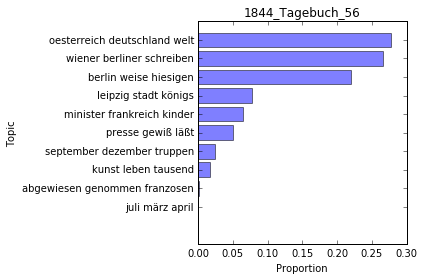

In [23]:
visualization.plot_doc_topics(document_topics, 0)